In [2]:
import pandas as pd
# Predict trends using linear regression
from sklearn.linear_model import LinearRegression

# Generate plots
import matplotlib.pyplot as plt


# Inputs: 
# 1) raw CPI data 
# 2) wage growth data - run make_data in wfh directory and wage_growth_wf_occ which generates the wage growth measure 

c:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\singhy\AppData\Local\Temp\ipykernel_20976\1550526224.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
proj_dir =  "C:/Users/singhy/Dropbox/Labor_Market_PT/replication/empirical"

df = pd.read_csv(f"{proj_dir}/temp/wfh_wage_growth.csv")
cpi = pd.read_csv(f"{proj_dir}/inputs/raw_data/CPI/CPIAUCSL.csv")


In [4]:

# Convert 'date_monthly' from '2016m1' format to datetime
df['date'] = pd.to_datetime(
    df['date_monthly'].str.extract(r'(\d{4})m(\d{1,2})')
    .apply(lambda x: f"{x[0]}-{int(x[1]):02d}", axis=1)
)


cpi['date'] = pd.to_datetime(cpi['observation_date'])
cpi = cpi.rename(columns={'CPIAUCSL': 'P'})
cpi['P'] = pd.to_numeric(cpi['P'], errors='coerce')
cpi['P_12m_change'] = cpi['P'].pct_change(periods=12) * 100
cpi['P_1m_change'] = 1 + (cpi['P_12m_change'] / 100) / 12
cpi = cpi[['date', 'P_1m_change']]

    # Merge CPI with wage growth data
df = df.merge(cpi, on='date', how='left')
    
# Compute monthly wage growth factors
wage_columns = [col for col in df.columns if col.startswith('smwg')]
for col in wage_columns:
    df[f'{col}_mom_grth'] = 1 + (df[col] / 100) / 12

# Compute nominal wage indices
for col in wage_columns:
    df[f'nom_index_{col}'] = df[f'{col}_mom_grth'].cumprod()

# Compute price index
df['price_index'] = df['P_1m_change'].cumprod()

# Compute real wage indices
for col in wage_columns:
        df[f'real_index_{col}'] = df[f'nom_index_{col}'] / df['price_index']

# Select final columns
result_cols = ['date', 'price_index'] + [f'real_index_{col}' for col in wage_columns]
result_df = df[result_cols]




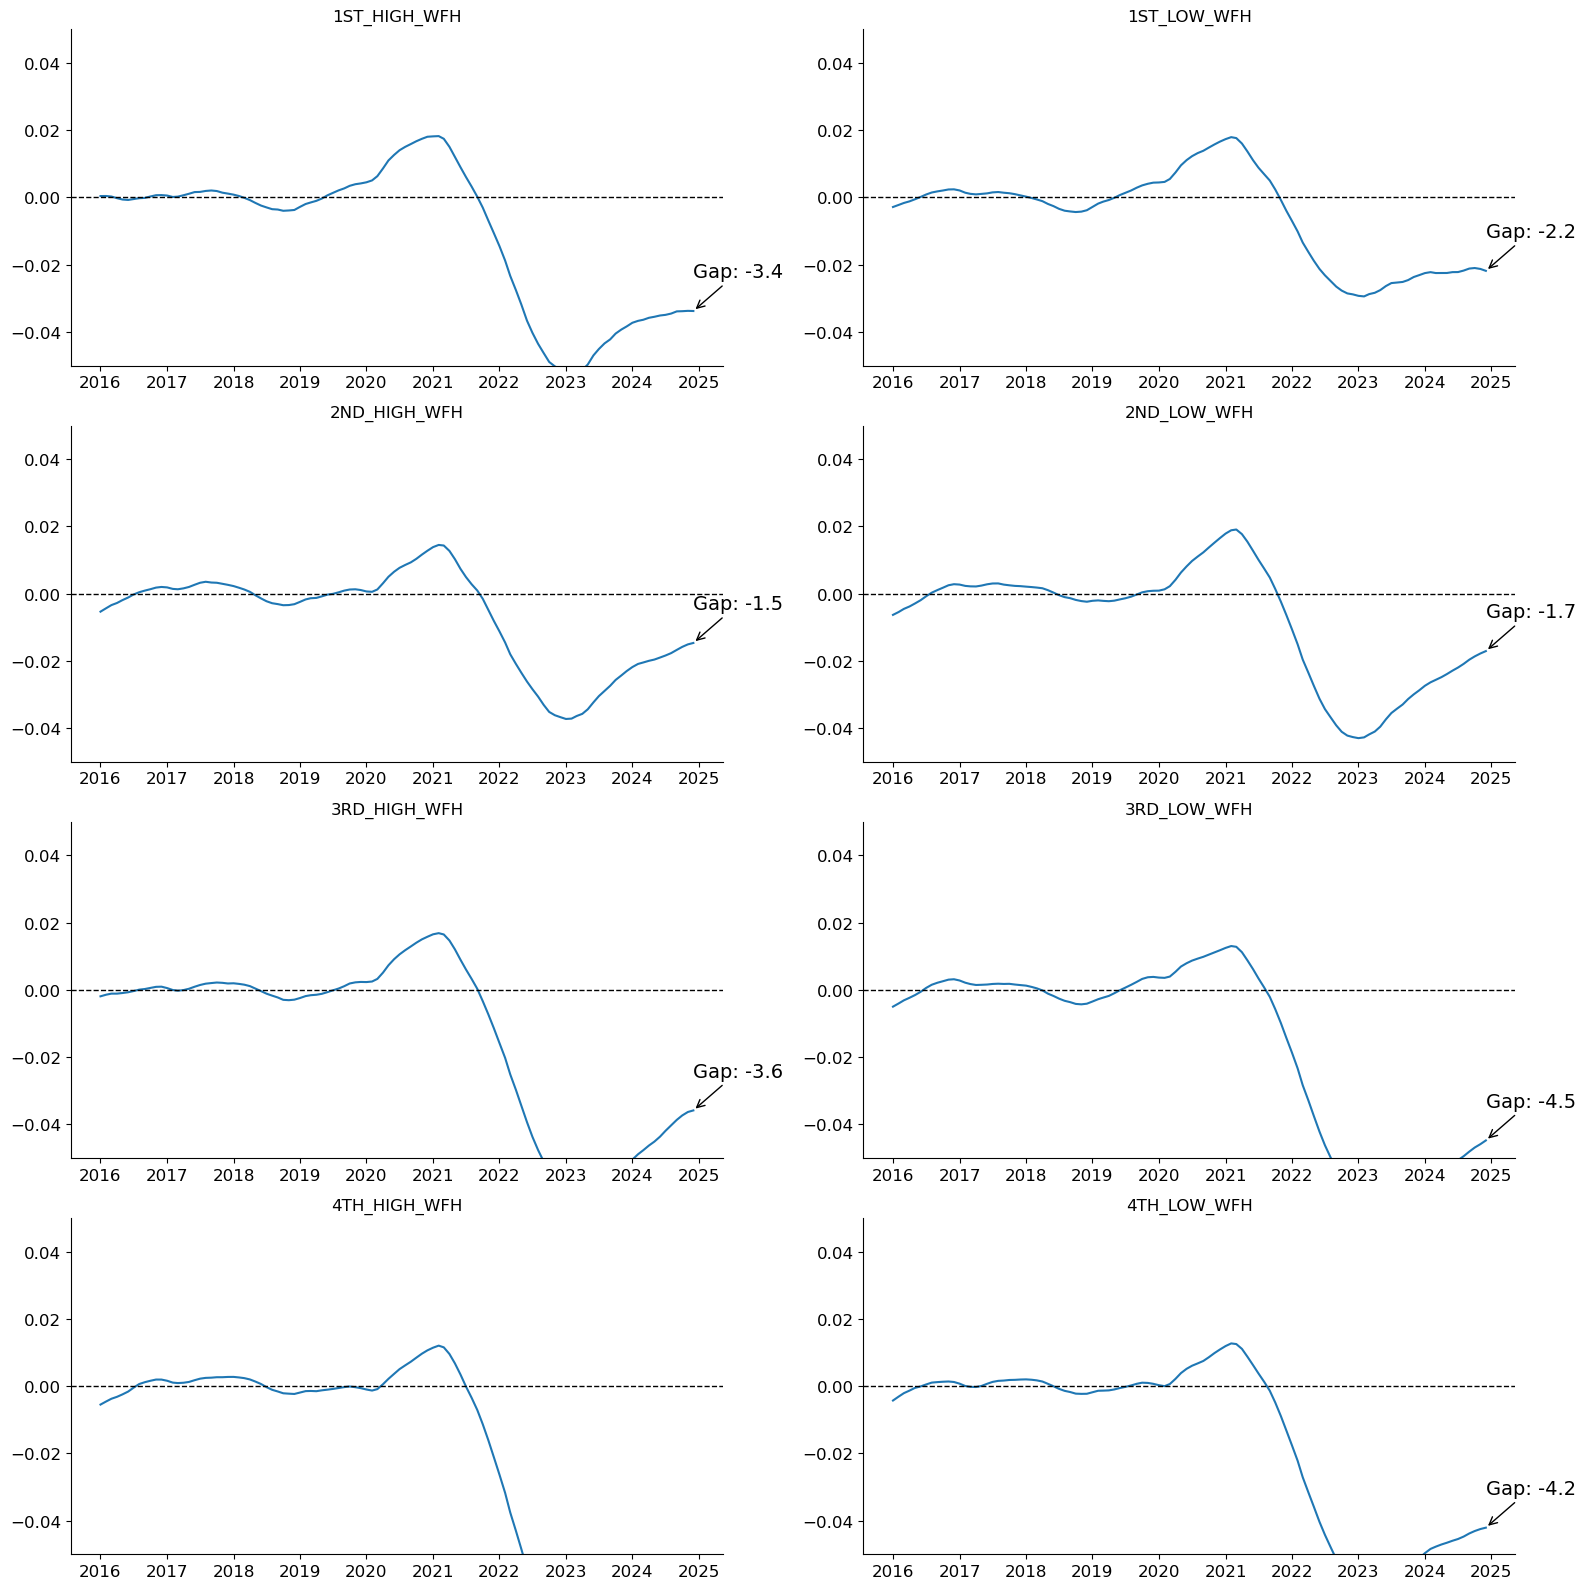

In [5]:
# Recalculate trend dataframe based on the existing df
start_date = pd.to_datetime("2016-01-01")
end_date = pd.to_datetime("2019-12-31")

trend_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
X_trend = ((trend_df['date'].dt.year - trend_df['date'].min().year) * 12 +
           (trend_df['date'].dt.month - trend_df['date'].min().month)).values.reshape(-1, 1)
X_all = ((df['date'].dt.year - trend_df['date'].min().year) * 12 +
         (df['date'].dt.month - trend_df['date'].min().month)).values.reshape(-1, 1)

# Identify real wage index columns
real_index_cols = [col for col in df.columns if col.startswith('real_index_')]

predicted = {}
for col in real_index_cols + ['price_index']:
    y = trend_df[col].values
    model = LinearRegression()
    model.fit(X_trend, y)
    predicted[col] = model.predict(X_all)
    df[f'predicted_{col}'] = predicted[col]

# Compute final gaps between actual and trend
gaps = {
    col: df[f'predicted_{col}'].iloc[-1] - df[col].iloc[-1]
    for col in real_index_cols + ['price_index']
}

import math

# Compute the number of rows needed for 2 columns
ncols = 2
nrows = math.ceil(len(real_index_cols) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(real_index_cols):
    ax = axes[i]
    
    # Compute deviation from trend
    deviation = df[col] - df[f'predicted_{col}']

    ax.plot(df['date'], deviation, label='Deviation from Trend')
    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # flat trend line at 0

    ax.set_title(col.replace("real_index_smwg", "").upper())
    ax.set_ylim(-0.05, 0.05)  # adjust as needed to center around 0

    # Annotate the final gap
    gap = deviation.iloc[-1]
    ax.annotate(f"Gap: {gap*100:.1f}",
                xy=(df['date'].iloc[-1], gap),
                xytext=(df['date'].iloc[-1], gap + 0.01),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=14)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=12)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.savefig(f"{proj_dir}/outputs/figures/wfh_wage_figures.pdf") 

plt.show()
